In [1]:
import torch
import os
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import sys

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as func


from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
from models.chexnet.DensenetModels import DenseNet121

In [2]:
"""
Read images and corresponding labels.
"""
class ChestXrayDataSet(Dataset):
    
    def convert_to_ones(self, df, disease):
        df[disease] = df[disease].replace([-1.0], 1.0)
    
    def convert_to_zeros(self, df, disease):
        df[disease] = df[disease].replace([-1.0], 0.0)
        
    def convert_to_multi(self, df, disease):
        df[disease] = df[disease].replace([-1.0], 2.0)

    def __init__(self, data_dir, image_list_file, diseases=['Atelectasis', 'Consolidation', 'Edema','Cardiomegaly', 'Pleural Effusion'], side='Frontal', transform=None):
        """
        Args:
            data_dir: path to image directory.
            image_list_file: path to the file containing images
                with corresponding labels.
            transform: optional transform to be applied on a sample.
        """
        image_names = []
        labels = []
        chex_df = pd.read_csv(image_list_file)
        chex_df = chex_df.fillna(0.0)
        chex_df = chex_df.loc[chex_df['Frontal/Lateral'] == side]
        self.convert_to_ones(chex_df, 'Atelectasis')
        self.convert_to_ones(chex_df, 'Consolidation')
        self.convert_to_ones(chex_df, 'Edema')
        self.convert_to_multi(chex_df, 'Cardiomegaly')
        self.convert_to_multi(chex_df, 'Pleural Effusion')

#         chex_df_diseases = chex_df[diseases]
                         
#         if 'train' in image_list_file:
#             chex_df = chex_df
#         if len(diseases) == 1:
#             chex_df = chex_df.loc[chex_df['Pleural Effusion'] != -1] #U-Ignore
#         print(chex_df)
        labels = chex_df.as_matrix(columns=diseases)
        labels = list(labels)

        image_names = chex_df.as_matrix(columns=['Path']).flatten()
        image_names = [os.path.join(data_dir, im_name) for im_name in image_names]

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_names[index]
        image = Image.open(image_name)
        label = torch.FloatTensor(self.labels[index])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_names)

In [62]:
BATCH_SIZE = 8
DATA_DIR = './data'
TRAIN_IMAGE_LIST = './data/CheXpert-v1.0-small/train.csv'
VAL_IMAGE_LIST = './data/CheXpert-v1.0-small/valid.csv'

normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])


transformList = []
transformList.append(transforms.RandomResizedCrop(transCrop))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(normalize)
transformSequence=transforms.Compose(transformList)

train_dataset = ChestXrayDataSet(data_dir=DATA_DIR,
                                image_list_file=TRAIN_IMAGE_LIST,
                                diseases =['Pleural Effusion'],
                                transform=transformSequence)

valid_dataset = ChestXrayDataSet(data_dir=DATA_DIR,
                                image_list_file=VAL_IMAGE_LIST,
                                diseases =['Pleural Effusion'],
                                transform=transformSequence)

dataLoaderTrain = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=1, pin_memory=True)
dataLoaderVal = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=1, pin_memory=True)


NameError: name 'transCrop' is not defined

In [60]:
nnClassCount = 2
nnIsTrained = True
model = DenseNet121(nnClassCount)#.cuda()
trMaxEpoch = 200


#-----Optimizer-------- #
optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')
                
#-------------------- SETTINGS: LOSS
loss = torch.nn.BCELoss(size_average = True)

#---- Load checkpoint 
# if checkpoint != None:
#     modelCheckpoint = torch.load(checkpoint)
#     model.load_state_dict(modelCheckpoint['state_dict'])
#     optimizer.load_state_dict(modelCheckpoint['optimizer'])

#---- TRAIN THE NETWORK

lossMIN = 100000

for epochID in range (0, trMaxEpoch):

    timestampTime = time.strftime("%H%M%S")
    timestampDate = time.strftime("%d%m%Y")
    timestampSTART = timestampDate + '-' + timestampTime

    epochTrain (model, dataLoaderTrain, optimizer, scheduler, trMaxEpoch, nnClassCount, loss)
    lossVal, losstensor = epochVal (model, dataLoaderVal, optimizer, scheduler, trMaxEpoch, nnClassCount, loss)

    timestampTime = time.strftime("%H%M%S")
    timestampDate = time.strftime("%d%m%Y")
    timestampEND = timestampDate + '-' + timestampTime

    scheduler.step(losstensor.data[0])

    if lossVal < lossMIN:
        lossMIN = lossVal    
        torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'm-' + launchTimestamp + '.pth.tar')
        print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
    else:
        print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))


RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 7 7 94548246147248, but got 5-dimensional input of size [8, 10, 3, 224, 224] instead

In [4]:
# ls = [ x[0] for x in iter(valid_loader).next() ]
for test_images, test_labels in valid_loader:    
    print(test_images[0][0].shape)
    plt.imshow(test_images[0][0][2,])
    plt.show()
    print(test_labels)
    break

NameError: name 'valid_loader' is not defined

In [4]:
import pandas as pd
import torchvision.transforms as transforms


BATCH_SIZE = 8
DATA_DIR = './data'
VALID_IMAGE_LIST = './data/CheXpert-v1.0-small/valid.csv'
TRAIN_IMAGE_LIST = './data/CheXpert-v1.0-small/train.csv'


chex_val_df = pd.read_csv(VALID_IMAGE_LIST)
chex_val_df = chex_val_df.fillna(0.0)
chex_train_df = pd.read_csv(TRAIN_IMAGE_LIST)
chex_train_df = chex_train_df.fillna(0.0)

def convert_to_ones(df, disease):
    df[disease] = df[disease].replace([-1.0], 1.0)
    
def convert_to_zeros(df, disease):
    df[disease] = df[disease].replace([-1.0], 0.0)

convert_to_ones(chex_train_df, 'Atelectasis')
convert_to_ones(chex_train_df, 'Edema')
convert_to_ones(chex_train_df, 'Consolidation')

chex_train_df = chex_train_df.loc[chex_train_df['Frontal/Lateral'] == 'Lateral']
chex_train_df
#U-Ones for Atelectasis and Edema, 
#UMultiClass for Cardiomegaly and Pleural Effusion, 
# chex_val_df_NOUNCERTAIN_PLEURAL = chex_val_df.loc[chex_val_df['Pleural Effusion'] != -1]
# chex_val_df_NOUNCERTAIN_PLEURAL

#On Atelectasis, the U-Ones model (AUC=0.858) significantly outperforms (p = 0.03) the U-Zeros model (AUC=0.811). On
#Cardiomegaly, we observe that the U-MultiClass model
#(AUC=0.854) performs significantly better (p < 0.01)
#than the U-Ignore model (AUC=0.828). On Consolidation, whatever


# chex_val_df_NOUNCERTAIN_PLEURAL = chex_val_df.loc[chex_val_df['Pleural Effusion'] != -1]
# a = chex_val_df.as_matrix(columns=['Path']).flatten()

# pleural_arr = list(chex_val_df_NOUNCERTAIN_PLEURAL.as_matrix(columns=['Pleural Effusion']).flatten())


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Lateral,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Lateral,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17,CheXpert-v1.0-small/train/patient00009/study1/...,Male,76,Lateral,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19,CheXpert-v1.0-small/train/patient00010/study1/...,Female,50,Lateral,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,CheXpert-v1.0-small/train/patient00011/study13...,Female,22,Lateral,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,CheXpert-v1.0-small/train/patient00012/study3/...,Female,61,Lateral,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
37,CheXpert-v1.0-small/train/patient00012/study2/...,Female,55,Lateral,0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39,CheXpert-v1.0-small/train/patient00012/study1/...,Female,55,Lateral,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41,CheXpert-v1.0-small/train/patient00013/study1/...,Male,36,Lateral,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


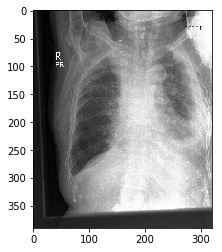

In [22]:
import os
import matplotlib.pyplot as plt
# import cv2
data_dir = './data/'
image_name = data_dir + 'patient18728/study6/view2_frontal.jpg'
# print(os.listdir(data_dir + 'patient18728/study6/view2_frontal.jpg'))
# print(os.listdir())

image = Image.open(image_name).convert('RGB')
plt.imshow(image)
plt.show()

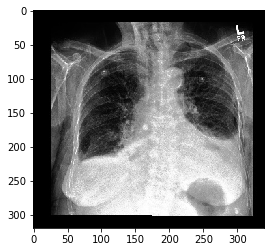

In [24]:
im = data_dir + 'patient18728/study6/view1_frontal.jpg'
im= Image.open(im).convert('RGB')
plt.imshow(im)
plt.show()

In [3]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transCrop = (300,300)

transformList = []
transformList.append(transforms.Resize(transCrop))
transformList.append(transforms.ToTensor())
# transformList.append(normalize)      
transformSequence=transforms.Compose(transformList)
                    
# datasetTrain = ChestXrayDataSet(data_dir=pathDirData,image_list_file=pathFileTrain, transform=transformSequence)              
# dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=trBatchSize, shuffle=True,  num_workers=4, pin_memory=True)

DATA_DIR = './data'
TRAIN_IMAGE_LIST = './data/CheXpert-v1.0-small/train.csv'
VAL_IMAGE_LIST = './data/CheXpert-v1.0-small/valid.csv'
valid_dataset = ChestXrayDataSet(data_dir=DATA_DIR,
                                 image_list_file=TRAIN_IMAGE_LIST, transform=transformSequence)
dataLoaderVal = DataLoader(dataset=valid_dataset, batch_size=1, shuffle=True,  num_workers=2, pin_memory=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [6]:
import numpy as np
samples = []
# samples = np.zeros((0, 300, 300))
for i in range(len(valid_dataset)):
    sample = valid_dataset[i]
#     print(sample[0].data.shape)
    samples.append(sample[0].data)
    #    torch.mean(sample[0], dim=[1,2])
#    torch.std(sample[0])
#     plt.imshow(sample[0].squeeze().data)
#     plt.show()
    if i == 5000:
        break
samples = np.vstack(samples)
print(np.mean(samples))
print(np.std(samples))

0.50616586
0.2879059
